# AQI Analysis for Cleveland, Los Angeles, New York, and Tampa (2022-2023 Data)

1. Data Wrangling

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import pickle
import seaborn as sns
%matplotlib inline
import string
import collections

from pandas.plotting import register_matplotlib_converters
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import text
import warnings
warnings.filterwarnings('ignore')

### Read Files

In [2]:
print('Cleveland-Elyria, OH: ')
df_cle22 = pd.read_csv(r'E:\Files\Github\CLE_Pollutants_22-23.csv')
print(df_cle22.head())
print('Los Angeles, CA: ')
df_la22 = pd.read_csv(r'E:\Files\Github\LA_Pollutants_22-23.csv')
print(df_la22.head())
print('New York-Newark-New Jersey, NY: ')
df_ny22 = pd.read_csv(r'E:\Files\Github\NY_Pollutants_22-23.csv')
print(df_ny22.head())
print('Tampa, FL: ')
df_tpa22 = pd.read_csv(r'E:\Files\Github\TPA_Pollutants_22-23.csv')
print(df_tpa22.head())

Cleveland-Elyria, OH: 
         Date   AQI Value Main Pollutant            Site Name      Site ID  \
0  01/01/2022          58          PM2.5  GT Craig NCore PAMS  39-035-0060   
1  01/02/2022          32          Ozone  GT Craig NCore PAMS  39-035-0060   
2  01/03/2022          31          Ozone  GT Craig NCore PAMS  39-035-0060   
3  01/04/2022          55          PM2.5        St Theodosius  39-035-0038   
4  01/05/2022          45          PM2.5        Harvard Yards  39-035-0065   

  Source  
0    AQS  
1    AQS  
2    AQS  
3    AQS  
4    AQS  
Los Angeles, CA: 
         Date   AQI Value Main Pollutant                       Site Name  \
0  01/01/2022         106          PM2.5                         Compton   
1  01/02/2022          49          PM2.5       Lancaster-Division Street   
2  01/03/2022          61          PM2.5  Long Beach-Route 710 Near Road   
3  01/04/2022          72          PM2.5                         Compton   
4  01/05/2022          94          PM2.5    

In [3]:
print(df_cle22.info())
print(df_la22.info())
print(df_ny22.info())
print(df_tpa22.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            526 non-null    object
 1    AQI Value      526 non-null    int64 
 2   Main Pollutant  526 non-null    object
 3   Site Name       526 non-null    object
 4   Site ID         526 non-null    object
 5   Source          526 non-null    object
dtypes: int64(1), object(5)
memory usage: 24.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            526 non-null    object
 1    AQI Value      526 non-null    int64 
 2   Main Pollutant  526 non-null    object
 3   Site Name       526 non-null    object
 4   Site ID         526 non-null    object
 5   Source          526 non-null    object
dtypes: int64(1), object(5)
memo

In [4]:
# Check nulls
print(df_cle22.isnull().sum())
print(df_la22.isnull().sum())
print(df_ny22.isnull().sum())
print(df_tpa22.isnull().sum())

Date              0
 AQI Value        0
Main Pollutant    0
Site Name         0
Site ID           0
Source            0
dtype: int64
Date              0
 AQI Value        0
Main Pollutant    0
Site Name         0
Site ID           0
Source            0
dtype: int64
Date              0
 AQI Value        0
Main Pollutant    0
Site Name         0
Site ID           0
Source            0
dtype: int64
Date              0
 AQI Value        0
Main Pollutant    0
Site Name         0
Site ID           0
Source            0
dtype: int64


In [5]:
# Check all pollutants listed per dataframe
print('Cleveland OH Pollutants: ', df_cle22['Main Pollutant'].unique())
print('Los Angeles CA Pollutants: ', df_la22['Main Pollutant'].unique())
print('New York-New Jersey NY Pollutants: ', df_ny22['Main Pollutant'].unique())
print('Tampa FL Pollutants: ', df_tpa22['Main Pollutant'].unique())

Cleveland OH Pollutants:  ['PM2.5' 'Ozone' 'PM10' 'NO2']
Los Angeles CA Pollutants:  ['PM2.5' 'NO2' 'PM10' 'Ozone']
New York-New Jersey NY Pollutants:  ['PM2.5' 'Ozone' 'NO2' 'CO']
Tampa FL Pollutants:  ['PM2.5' 'Ozone' 'PM10' 'NO2']


NY-NJ has no PM10, so only look at PM2.5, Ozone, and NO2

### Pivoted & Reset

In [6]:
print('CLE Pivots: ')
pivot = df_cle22.pivot_table(index=['Date', 'Main Pollutant'])
print(pivot)
print('LA Pivots: ')
pivot0 = df_la22.pivot_table(index=['Date', 'Main Pollutant'])
print(pivot0)
print('NY-NJ Pivots: ')
pivot1 = df_ny22.pivot_table(index=['Date', 'Main Pollutant'])
print(pivot1)
print('TPA Pivots: ')
pivot2 = df_tpa22.pivot_table(index=['Date', 'Main Pollutant'])
print(pivot2)

CLE Pivots: 
                            AQI Value
Date       Main Pollutant            
01/01/2022 PM2.5                   58
01/01/2023 PM2.5                   57
01/02/2022 Ozone                   32
01/02/2023 PM2.5                   59
01/03/2022 Ozone                   31
...                               ...
12/27/2022 PM2.5                   67
12/28/2022 PM2.5                   56
12/29/2022 PM2.5                   39
12/30/2022 PM2.5                   40
12/31/2022 PM2.5                   57

[526 rows x 1 columns]
LA Pivots: 
                            AQI Value
Date       Main Pollutant            
01/01/2022 PM2.5                  106
01/01/2023 Ozone                   36
01/02/2022 PM2.5                   49
01/02/2023 PM2.5                   49
01/03/2022 PM2.5                   61
...                               ...
12/27/2022 PM2.5                   72
12/28/2022 PM2.5                   53
12/29/2022 PM2.5                   47
12/30/2022 PM2.5                   45
1

In [7]:
print('CLE Resets: ')
reset = pivot.reset_index()
print(reset)
print('LA Resets: ')
reset0 = pivot0.reset_index()
print(reset0)
print('NY-NJ Resets: ')
reset1 = pivot1.reset_index()
print(reset1)
print('TPA Resets: ')
reset2 = pivot2.reset_index()
print(reset2)

CLE Resets: 
           Date Main Pollutant   AQI Value
0    01/01/2022          PM2.5          58
1    01/01/2023          PM2.5          57
2    01/02/2022          Ozone          32
3    01/02/2023          PM2.5          59
4    01/03/2022          Ozone          31
..          ...            ...         ...
521  12/27/2022          PM2.5          67
522  12/28/2022          PM2.5          56
523  12/29/2022          PM2.5          39
524  12/30/2022          PM2.5          40
525  12/31/2022          PM2.5          57

[526 rows x 3 columns]
LA Resets: 
           Date Main Pollutant   AQI Value
0    01/01/2022          PM2.5         106
1    01/01/2023          Ozone          36
2    01/02/2022          PM2.5          49
3    01/02/2023          PM2.5          49
4    01/03/2022          PM2.5          61
..          ...            ...         ...
521  12/27/2022          PM2.5          72
522  12/28/2022          PM2.5          53
523  12/29/2022          PM2.5          47
524  

### Preliminary Evaluation of Pollutants

In [8]:
print('CLE pollutants datasets: ')
# Create separate df for each pollutant
pm25_cle = reset[reset["Main Pollutant"]=="PM2.5"]
ozo_cle = reset[reset["Main Pollutant"]=="Ozone"]
pm10_cle = reset[reset["Main Pollutant"]=="PM10"]
no2_cle = reset[reset["Main Pollutant"]=="NO2"]
print(pm25_cle.info())
print(ozo_cle.info())
print(pm10_cle.info())
print(no2_cle.info())


print('LA pollutants datasets: ')
# Create separate df for each pollutant
pm25_la = reset0[reset0["Main Pollutant"]=="PM2.5"]
ozo_la = reset0[reset0["Main Pollutant"]=="Ozone"]
pm10_la = reset0[reset0["Main Pollutant"]=="PM10"]
no2_la = reset0[reset0["Main Pollutant"]=="NO2"]
print(pm25_la.info())
print(ozo_la.info())
print(pm10_la.info())
print(no2_cle.info())

print('NY-NJ pollutants datasets: ')
# Create separate df for each pollutant
pm25_ny = reset1[reset1["Main Pollutant"]=="PM2.5"]
ozo_ny = reset1[reset1["Main Pollutant"]=="Ozone"]
pm10_ny = reset1[reset1["Main Pollutant"]=="PM10"]
no2_ny = reset1[reset1["Main Pollutant"]=="NO2"]
print(pm25_ny.info())
print(ozo_ny.info())
print(pm10_ny.info())
print(no2_ny.info())

print('TPA pollutants datasets: ')
# Create separate df for each pollutant
pm25_tpa = reset2[reset2["Main Pollutant"]=="PM2.5"]
ozo_tpa = reset2[reset2["Main Pollutant"]=="Ozone"]
pm10_tpa = reset2[reset2["Main Pollutant"]=="PM10"]
no2_tpa = reset2[reset2["Main Pollutant"]=="NO2"]
print(pm25_tpa.info())
print(ozo_tpa.info())
print(pm10_tpa.info())
print(no2_tpa.info())


CLE pollutants datasets: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 274 entries, 0 to 525
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            274 non-null    object
 1   Main Pollutant  274 non-null    object
 2    AQI Value      274 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 236 entries, 2 to 519
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            236 non-null    object
 1   Main Pollutant  236 non-null    object
 2    AQI Value      236 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 7.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 20 to 517
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            11 

There seems to be only few data for Tampa, FL for NO2. We'll just look at PM2.5 and Ozone pollutants

In [9]:
###  95% quantile for each main pollutant ###
print('----------------------------------------------')
print('CLE 95% quantile, PM2.5 and Ozone: ')
print('PM2.5 95 quantile: ', pm25_cle.quantile(0.95))
print('Ozone 95 quantile: ', ozo_cle.quantile(0.95))

print('----------------------------------------------')
print('LA 95% quantile, PM2.5 and Ozone: ')
print('PM2.5 95 quantile: ', pm25_la.quantile(0.95))
print('Ozone 95 quantile: ', ozo_la.quantile(0.95))

print('----------------------------------------------')
print('NY-NJ 95% quantile, PM2.5 and Ozone: ')
print('PM2.5 95 quantile: ', pm25_ny.quantile(0.95))
print('Ozone 95 quantile: ', ozo_ny.quantile(0.95))

print('----------------------------------------------')
print('TPA 95% quantile, PM2.5 and Ozone: ')
print('PM2.5 95 quantile: ', pm25_tpa.quantile(0.95))
print('Ozone 95 quantile: ', ozo_tpa.quantile(0.95))


###  Averages for each pollutant  ###
print('----------------------------------------------')
print('CLE Averages, PM2.5 and Ozone: ')
print('PM2.5 average: ', pm25_cle.mean())
print('Ozone average: ', ozo_cle.mean())

print('----------------------------------------------')
print('LA Averages, PM2.5 and Ozone: ')
print('PM2.5 average: ', pm25_la.mean())
print('Ozone average: ', ozo_la.mean())

print('----------------------------------------------')
print('NY-NJ Averages, PM2.5 and Ozone: ')
print('PM2.5 average: ', pm25_ny.mean())
print('Ozone average: ', ozo_ny.mean())

print('----------------------------------------------')
print('TPA Averages, PM2.5 and Ozone: ')
print('PM2.5 average: ', pm25_tpa.mean())
print('Ozone average: ', ozo_tpa.mean())

----------------------------------------------
CLE 95% quantile, PM2.5 and Ozone: 
PM2.5 95 quantile:   AQI Value    81.35
Name: 0.95, dtype: float64
Ozone 95 quantile:   AQI Value    100.25
Name: 0.95, dtype: float64
----------------------------------------------
LA 95% quantile, PM2.5 and Ozone: 
PM2.5 95 quantile:   AQI Value    91.2
Name: 0.95, dtype: float64
Ozone 95 quantile:   AQI Value    161.0
Name: 0.95, dtype: float64
----------------------------------------------
NY-NJ 95% quantile, PM2.5 and Ozone: 
PM2.5 95 quantile:   AQI Value    75.6
Name: 0.95, dtype: float64
Ozone 95 quantile:   AQI Value    106.95
Name: 0.95, dtype: float64
----------------------------------------------
TPA 95% quantile, PM2.5 and Ozone: 
PM2.5 95 quantile:   AQI Value    65.0
Name: 0.95, dtype: float64
Ozone 95 quantile:   AQI Value    84.0
Name: 0.95, dtype: float64
----------------------------------------------
CLE Averages, PM2.5 and Ozone: 
PM2.5 average:   AQI Value    53.748175
dtype: float64

# Data Manipulation and Transformation

### Min & Max Threshold

In [10]:
# Create max threshold and find outliers from it
max_thresh = pm25_cle.quantile(0.95)
outliers = pm25_cle[pm25_cle[' AQI Value'].values > max_thresh.values]
print('CLE max threshold: ')
outliers.info()

max_thresh0 = pm25_la.quantile(0.95)
outliers0 = pm25_la[pm25_la[' AQI Value'].values > max_thresh0.values]
print('LA max threshold: ')
outliers0.info()

max_thresh1 = pm25_ny.quantile(0.95)
outliers1 = pm25_ny[pm25_ny[' AQI Value'].values > max_thresh1.values]
print('NY-NJ max threshold: ')
outliers1.info()

max_thresh2 = pm25_tpa.quantile(0.95)
outliers2 = pm25_tpa[pm25_tpa[' AQI Value'].values > max_thresh2.values]
print('TPA max threshold: ')
outliers2.info()

CLE max threshold: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 60 to 515
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            14 non-null     object
 1   Main Pollutant  14 non-null     object
 2    AQI Value      14 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 448.0+ bytes
LA max threshold: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 519
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            11 non-null     object
 1   Main Pollutant  11 non-null     object
 2    AQI Value      11 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 352.0+ bytes
NY-NJ max threshold: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 24 to 525
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          -------------

In [11]:
# Do the same thing with min threshold, except set quantile to 5%
min_thresh = pm25_cle.quantile(0.05)
outliers_min = pm25_cle[pm25_cle[' AQI Value'].values > min_thresh.values]
print('CLE min threshold: ')
outliers_min.info()

min_thresh0 = pm25_la.quantile(0.05)
outliers_min0 = pm25_la[pm25_la[' AQI Value'].values > min_thresh0.values]
print('LA min threshold: ')
outliers_min0.info()

min_thresh1 = pm25_ny.quantile(0.05)
outliers_min1 = pm25_ny[pm25_ny[' AQI Value'].values > min_thresh1.values]
print('NY-NJ min threshold: ')
outliers_min1.info()

min_thresh2 = pm25_tpa.quantile(0.05)
outliers_min2 = pm25_tpa[pm25_tpa[' AQI Value'].values > min_thresh2.values]
print('TPA min threshold: ')
outliers_min2.info()

CLE min threshold: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 258 entries, 0 to 525
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            258 non-null    object
 1   Main Pollutant  258 non-null    object
 2    AQI Value      258 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 8.1+ KB
LA min threshold: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 524
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            196 non-null    object
 1   Main Pollutant  196 non-null    object
 2    AQI Value      196 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 6.1+ KB
NY-NJ min threshold: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 211 entries, 0 to 525
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 

### IQR

In [12]:
# New ds with 'Date' indexed
pm25_cle_indexed = pm25_cle.set_index('Date')

# calculate Q1 and Q3
Q1_cle = pm25_cle_indexed.quantile(0.25)
Q3_cle = pm25_cle_indexed.quantile(0.75)

# calculate the IQR
IQR_cle = Q3_cle - Q1_cle

# filter the dataset with the IQR
IQR_outliers0 = pm25_cle_indexed[((pm25_cle_indexed < (Q1_cle - 1.5 * IQR_cle)) |(pm25_cle_indexed > (Q3_cle + 1.5 * IQR_cle))).any(axis=1)]
print('--------------------------------------')
print('CLE IQR outliers: ')
print(IQR_outliers0.count())



# Do the same for LA. New ds with 'Date' indexed
pm25_la_indexed = pm25_la.set_index('Date')

# calculate Q1 and Q3
Q1_la = pm25_la_indexed.quantile(0.25)
Q3_la = pm25_la_indexed.quantile(0.75)

# calculate the IQR
IQR_la = Q3_la - Q1_la

# filter the dataset with the IQR
IQR_outliers1 = pm25_la_indexed[((pm25_la_indexed < (Q1_la - 1.5 * IQR_la)) |(pm25_la_indexed > (Q3_la + 1.5 * IQR_la))).any(axis=1)]
print('--------------------------------------')
print('LA IQR outliers: ')
print(IQR_outliers1.count())


# New ds with 'Date' indexed
pm25_ny_indexed = pm25_ny.set_index('Date')

# calculate Q1 and Q3
Q1_ny = pm25_ny_indexed.quantile(0.25)
Q3_ny = pm25_ny_indexed.quantile(0.75)

# calculate the IQR
IQR_ny = Q3_ny - Q1_ny

# filter the dataset with the IQR
IQR_outliers2 = pm25_ny_indexed[((pm25_ny_indexed < (Q1_ny - 1.5 * IQR_ny)) |(pm25_ny_indexed > (Q3_ny + 1.5 * IQR_ny))).any(axis=1)]
print('--------------------------------------')
print('NY-NJ IQR outliers: ')
print(IQR_outliers2.count())


# Lastly, for Tampa. New ds with 'Date' indexed
pm25_tpa_indexed = pm25_tpa.set_index('Date')

# calculate Q1 and Q3
Q1_tpa = pm25_tpa_indexed.quantile(0.25)
Q3_tpa = pm25_tpa_indexed.quantile(0.75)

# calculate the IQR
IQR_tpa = Q3_tpa - Q1_tpa

# filter the dataset with the IQR
IQR_outliers3 = pm25_tpa_indexed[((pm25_tpa_indexed < (Q1_tpa - 1.5 * IQR_tpa)) |(pm25_tpa_indexed > (Q3_tpa + 1.5 * IQR_tpa))).any(axis=1)]
print('--------------------------------------')
print('TPA IQR outliers: ')
print(IQR_outliers3.count())

--------------------------------------
CLE IQR outliers: 
Main Pollutant    9
 AQI Value        9
dtype: int64
--------------------------------------
LA IQR outliers: 
Main Pollutant    13
 AQI Value        13
dtype: int64
--------------------------------------
NY-NJ IQR outliers: 
Main Pollutant    6
 AQI Value        6
dtype: int64
--------------------------------------
TPA IQR outliers: 
Main Pollutant    2
 AQI Value        2
dtype: int64


In [13]:
print('CLE IQR: ', IQR_outliers0.shape)
print('LA IQR: ', IQR_outliers1.shape)
print('NY-NJ IQR: ', IQR_outliers2.shape)
print('TPA IQR: ', IQR_outliers3.shape)

CLE IQR:  (9, 2)
LA IQR:  (13, 2)
NY-NJ IQR:  (6, 2)
TPA IQR:  (2, 2)


#### Z-Score

In [14]:
# Import stats
from scipy import stats

print('------------------------------------------')
# Let's look at z-score
# Separate ds with just date and aqi values
pm25_cle_values = pm25_cle[['Date', ' AQI Value']]

# DS with date indexed
pm25_cle_ = pm25_cle_values.set_index('Date')
# Calculate the z-scores
z_scores_cle = stats.zscore(pm25_cle_)
print('CLE Z-score: ', z_scores_cle)

#Here, we'll rule out any values above or below 3, as any value with a z-score below -3 or above +3 
#can be treated as outliers. This is because it's common threshold is that 99.7% of the values in a 
#standard normal distribution fall between -3 and +3.

# Convert to absolute values
z_score_abs0 = np.abs(z_scores_cle)

# Filter data points with z-scores > or < 3
thresh_z_score0 = (z_score_abs0 < 3).all(axis=1)

# Filter 
no_outliers_z_score0 = pm25_cle_[thresh_z_score0]
print('CLE data entries with no outliers: ', no_outliers_z_score0.shape)


# Let's do the same for LA, NY-NJ, and TPA
print('------------------------------------------')
# Separate ds with just date and aqi values
pm25_la_values = pm25_la[['Date', ' AQI Value']]

# DS with date indexed
pm25_la_ = pm25_la_values.set_index('Date')
# Calculate the z-scores
z_scores_la = stats.zscore(pm25_la_)
print('LA Z-score: ', z_scores_la)
# Convert to absolute values
z_score_abs1 = np.abs(z_scores_la)

# Filter data points with z-scores > or < 3
thresh_z_score1 = (z_score_abs1 < 3).all(axis=1)

# Filter 
no_outliers_z_score1 = pm25_la_[thresh_z_score1]
print('LA data entries with no outliers: ', no_outliers_z_score1.shape)

print('------------------------------------------')
# Separate ds with just date and aqi values
pm25_ny_values = pm25_ny[['Date', ' AQI Value']]

# DS with date indexed
pm25_ny_ = pm25_ny_values.set_index('Date')
# Calculate the z-scores
z_scores_ny = stats.zscore(pm25_ny_)
print('NY-NJ Z-score: ', z_scores_ny)
# Convert to absolute values
z_score_abs2 = np.abs(z_scores_ny)

# Filter data points with z-scores > or < 3
thresh_z_score2 = (z_score_abs2 < 3).all(axis=1)

# Filter 
no_outliers_z_score2 = pm25_ny_[thresh_z_score2]
print('NY-NJ data entries with no outliers: ', no_outliers_z_score2.shape)

print('------------------------------------------')
# Separate ds with just date and aqi values
pm25_tpa_values = pm25_tpa[['Date', ' AQI Value']]

# DS with date indexed
pm25_tpa_ = pm25_tpa_values.set_index('Date')
# Calculate the z-scores
z_scores_tpa = stats.zscore(pm25_tpa_)
print('TPA Z-score: ', z_scores_tpa)
# Convert to absolute values
z_score_abs3 = np.abs(z_scores_tpa)

# Filter data points with z-scores > or < 3
thresh_z_score3 = (z_score_abs3 < 3).all(axis=1)

# Filter 
no_outliers_z_score3 = pm25_tpa_[thresh_z_score3]
print('TPA data entries with no outliers: ', no_outliers_z_score3.shape)

------------------------------------------
CLE Z-score:               AQI Value
Date                  
01/01/2022    0.238579
01/01/2023    0.182467
01/02/2023    0.294691
01/03/2023    0.126355
01/04/2022    0.070243
...                ...
12/27/2022    0.743588
12/28/2022    0.126355
12/29/2022   -0.827551
12/30/2022   -0.771439
12/31/2022    0.182467

[274 rows x 1 columns]
CLE data entries with no outliers:  (269, 1)
------------------------------------------
LA Z-score:               AQI Value
Date                  
01/01/2022    2.545660
01/02/2022   -0.814984
01/02/2023   -0.814984
01/03/2022   -0.107480
01/04/2022    0.541066
...                ...
12/26/2022    1.307528
12/27/2022    0.541066
12/28/2022   -0.579149
12/29/2022   -0.932901
12/30/2022   -1.050818

[209 rows x 1 columns]
LA data entries with no outliers:  (204, 1)
------------------------------------------
NY-NJ Z-score:               AQI Value
Date                  
01/01/2022   -0.525574
01/01/2023   -0.525574
0

### Histograms

CLE histogram:


array([[<Axes: title={'center': ' AQI Value'}>]], dtype=object)

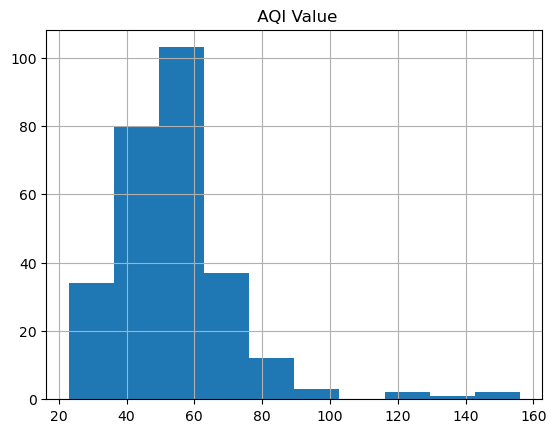

In [15]:
print('CLE histogram:')
pm25_cle_indexed.hist()

LA histogram:


array([[<Axes: title={'center': ' AQI Value'}>]], dtype=object)

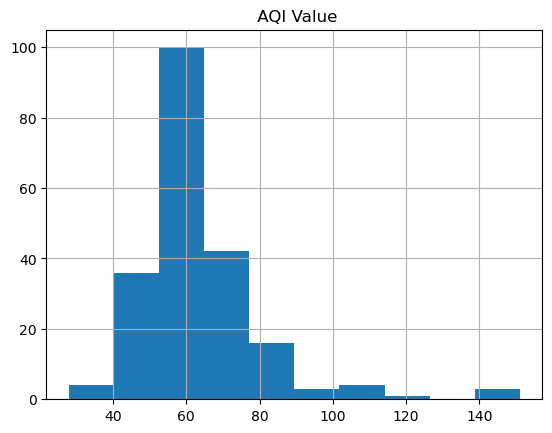

In [16]:
print('LA histogram:')
pm25_la_indexed.hist()

NY-NJ histogram:


array([[<Axes: title={'center': ' AQI Value'}>]], dtype=object)

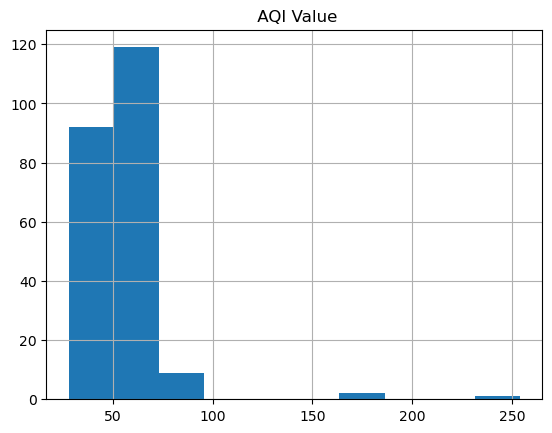

In [17]:
print('NY-NJ histogram:')
pm25_ny_indexed.hist()

TPA histogram:


array([[<Axes: title={'center': ' AQI Value'}>]], dtype=object)

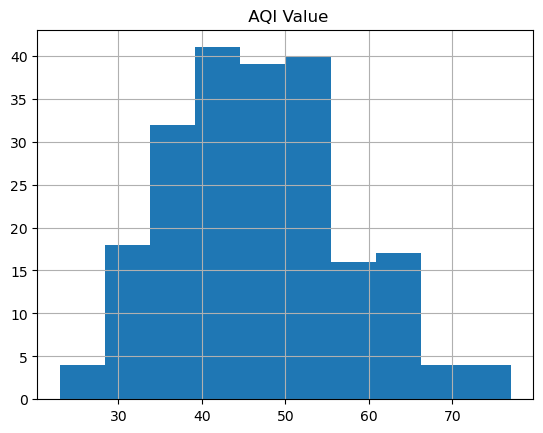

In [18]:
print('TPA histogram:')
pm25_tpa_indexed.hist()

Our original data is somewhat skewed (well, except Tampa), so we will go with using IQR to remove outliers.

In [19]:
# Reset index for IQR outliers subset and PM2.5 original data
IQR_outliers0_reset = IQR_outliers0.reset_index()
pm25_cle_indexed_reset = pm25_cle_indexed.reset_index()

print(IQR_outliers0_reset.shape)
print(pm25_cle_indexed_reset.shape)

(9, 3)
(274, 3)


In [20]:
data_clean0 = pm25_cle_indexed_reset.drop(IQR_outliers0_reset.index)
data_clean0

,Date,Main Pollutant,AQI Value
9,01/07/2022,PM2.5,52
10,01/07/2023,PM2.5,44
11,01/08/2022,PM2.5,56
12,01/08/2023,PM2.5,36
13,01/09/2023,PM2.5,67
...,...,...,...
269,12/27/2022,PM2.5,67
270,12/28/2022,PM2.5,56
271,12/29/2022,PM2.5,39
272,12/30/2022,PM2.5,40


In [21]:
# Do the same for the rest of the cities
IQR_outliers1_reset = IQR_outliers1.reset_index()
pm25_la_indexed_reset = pm25_la_indexed.reset_index()
data_clean1 = pm25_la_indexed_reset.drop(IQR_outliers1_reset.index)

print('LA final PM 2.5 Dataset: ')
print(IQR_outliers1_reset.shape)
print(pm25_la_indexed_reset.shape)
print(data_clean1.shape)
print('---------------------------------------')

IQR_outliers2_reset = IQR_outliers2.reset_index()
pm25_ny_indexed_reset = pm25_ny_indexed.reset_index()
data_clean2 = pm25_ny_indexed_reset.drop(IQR_outliers2_reset.index)
print('NY-NJ final PM 2.5 Dataset: ')
print(IQR_outliers2_reset.shape)
print(pm25_ny_indexed_reset.shape)
print(data_clean2.shape)
print('---------------------------------------')

IQR_outliers3_reset = IQR_outliers3.reset_index()
pm25_tpa_indexed_reset = pm25_tpa_indexed.reset_index()
data_clean3 = pm25_tpa_indexed_reset.drop(IQR_outliers3_reset.index)
print('TPA final PM 2.5 Dataset: ')
print(IQR_outliers3_reset.shape)
print(pm25_tpa_indexed_reset.shape)
print(data_clean3.shape)
print('---------------------------------------')

LA final PM 2.5 Dataset: 
(13, 3)
(209, 3)
(196, 3)
---------------------------------------
NY-NJ final PM 2.5 Dataset: 
(6, 3)
(223, 3)
(217, 3)
---------------------------------------
TPA final PM 2.5 Dataset: 
(2, 3)
(215, 3)
(213, 3)
---------------------------------------


In [22]:
# Save Files
data_clean0.to_excel('data_clean0_cle_22-23.xlsx')

In [23]:
data_clean1.to_excel('data_clean1_la_22-23.xlsx')

In [24]:
data_clean2.to_excel('data_clean2_ny_22-23.xlsx')

In [25]:
data_clean3.to_excel('data_clean3_tpa_22-23.xlsx')

# Time Series for All Pollutants - 2022 to 2023 data

In [22]:
# Consolidate data for PM2.5
# Add a 'City' column
data_clean0['City']='Cleveland'
data_clean1['City']='Los Angeles'
data_clean2['City']='New York-New Jersey'
data_clean3['City']='Tampa'

# Combine all tables
cle_la = data_clean0.append(data_clean1, ignore_index=True)
ny_tpa = data_clean2.append(data_clean3, ignore_index=True)
all_cities = cle_la.append(ny_tpa, ignore_index=True)
all_cities['City'].unique()

array(['Cleveland', 'Los Angeles', 'New York-New Jersey', 'Tampa'],
      dtype=object)

In [23]:
all_cities.columns

Index(['Date', 'Main Pollutant', ' AQI Value', 'City'], dtype='object')

In [24]:
# Separate dataset for histogram
df_all_cities = all_cities[[' AQI Value', 'City']]

In [25]:
df_all_cities

,AQI Value,City
0,52,Cleveland
1,44,Cleveland
2,56,Cleveland
3,36,Cleveland
4,67,Cleveland
...,...,...
886,45,Tampa
887,40,Tampa
888,45,Tampa
889,34,Tampa


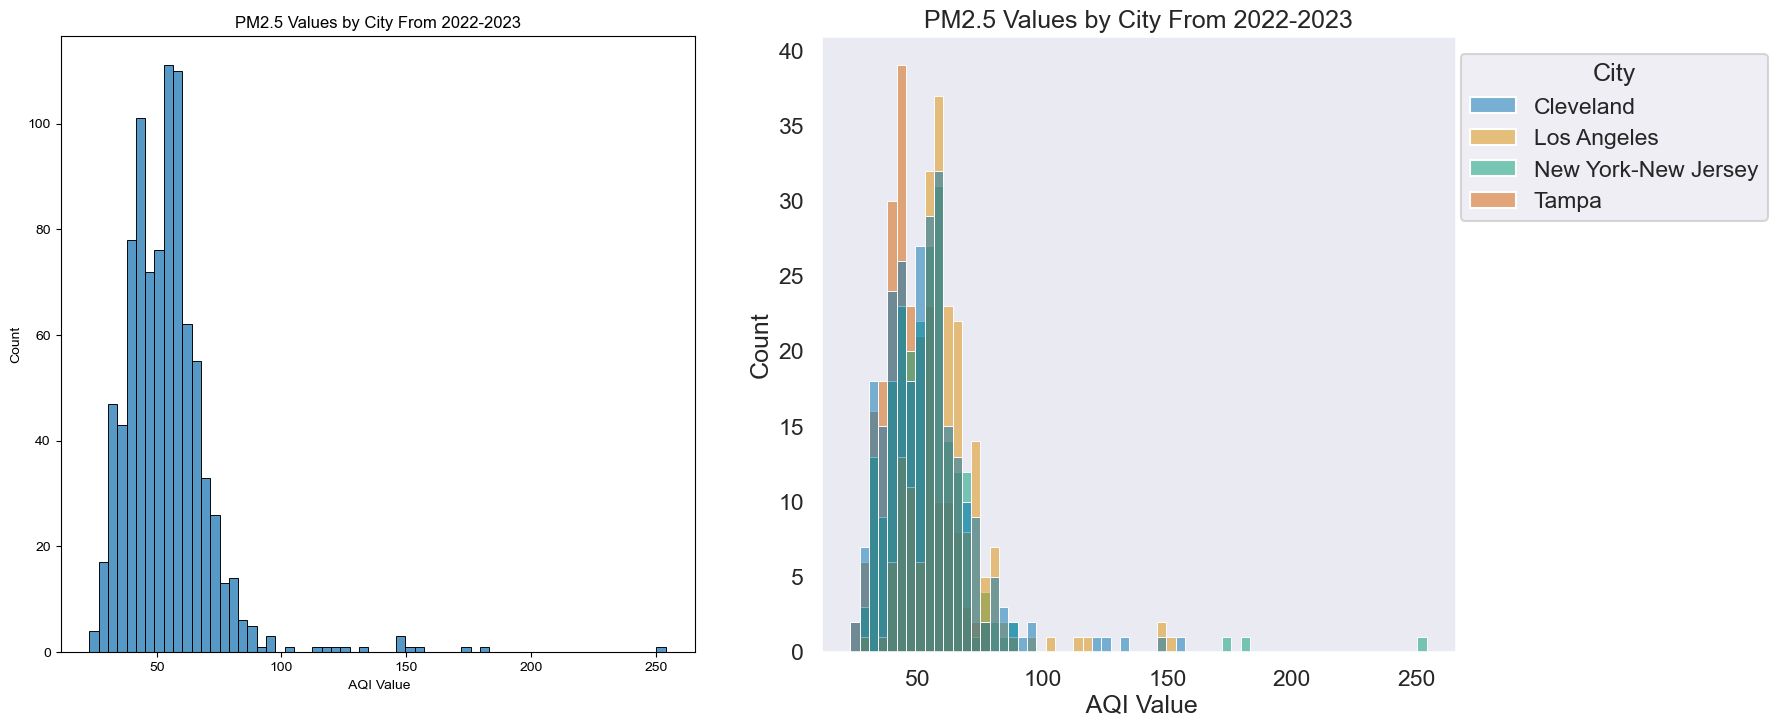

In [26]:
# histogram for all the cleaned datasets
fig = plt.figure(figsize=(18,8))
plt.subplot(121)
plt.title("PM2.5 Values by City From 2022-2023")
sns.histplot(data=df_all_cities,x=' AQI Value',cbar= True)
sns.set_style("dark")
sns.set_context("talk")
plt.subplot(122)
plt.title("PM2.5 Values by City From 2022-2023")
g = sns.histplot(data=df_all_cities,x=' AQI Value',hue= 'City',palette='colorblind',legend=True)
sns.move_legend(g, "upper left", bbox_to_anchor=(.99, .99), title='City')
plt.show()

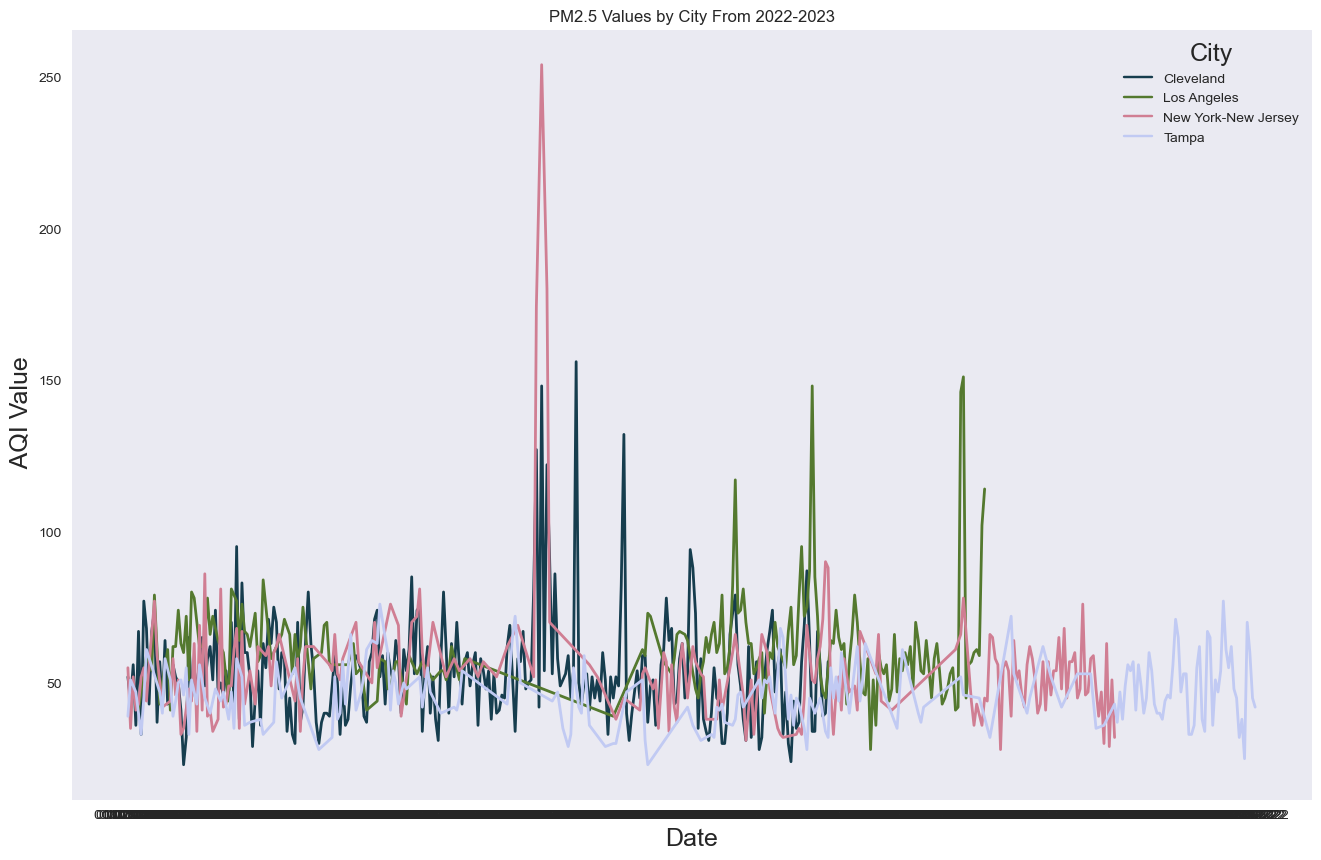

In [27]:
# Create time series for PM2.5 polllutant
plt.style.use('seaborn')
plt.figure(figsize=(16,10))
sns.lineplot(data=all_cities, x='Date', y=' AQI Value', hue='City', palette='cubehelix', linewidth= 2.0)
plt.grid(False)
plt.title('PM2.5 Values by City From 2022-2023')
plt.show()

#### Monthly

In [33]:
# Create copy of dataset
all_cities_copy = all_cities.copy()

# Create column for month
all_cities_copy['Date'] = pd.to_datetime(all_cities_copy['Date'], errors='coerce')
all_cities_copy['Month'] = all_cities_copy['Date'].dt.month_name()
print(all_cities_copy)

# Average Monthly data
per_month = all_cities_copy.groupby(['Month', 'City'],as_index=False).mean()
print(per_month)

          Date Main Pollutant   AQI Value       City     Month
0   2022-01-07          PM2.5          52  Cleveland   January
1   2023-01-07          PM2.5          44  Cleveland   January
2   2022-01-08          PM2.5          56  Cleveland   January
3   2023-01-08          PM2.5          36  Cleveland   January
4   2023-01-09          PM2.5          67  Cleveland   January
..         ...            ...         ...        ...       ...
886 2022-12-22          PM2.5          45      Tampa  December
887 2022-12-26          PM2.5          40      Tampa  December
888 2022-12-28          PM2.5          45      Tampa  December
889 2022-12-30          PM2.5          34      Tampa  December
890 2022-12-31          PM2.5          32      Tampa  December

[891 rows x 5 columns]
        Month                 City   AQI Value
0       April            Cleveland   53.400000
1       April          Los Angeles   57.470588
2       April  New York-New Jersey   56.875000
3       April                Tam

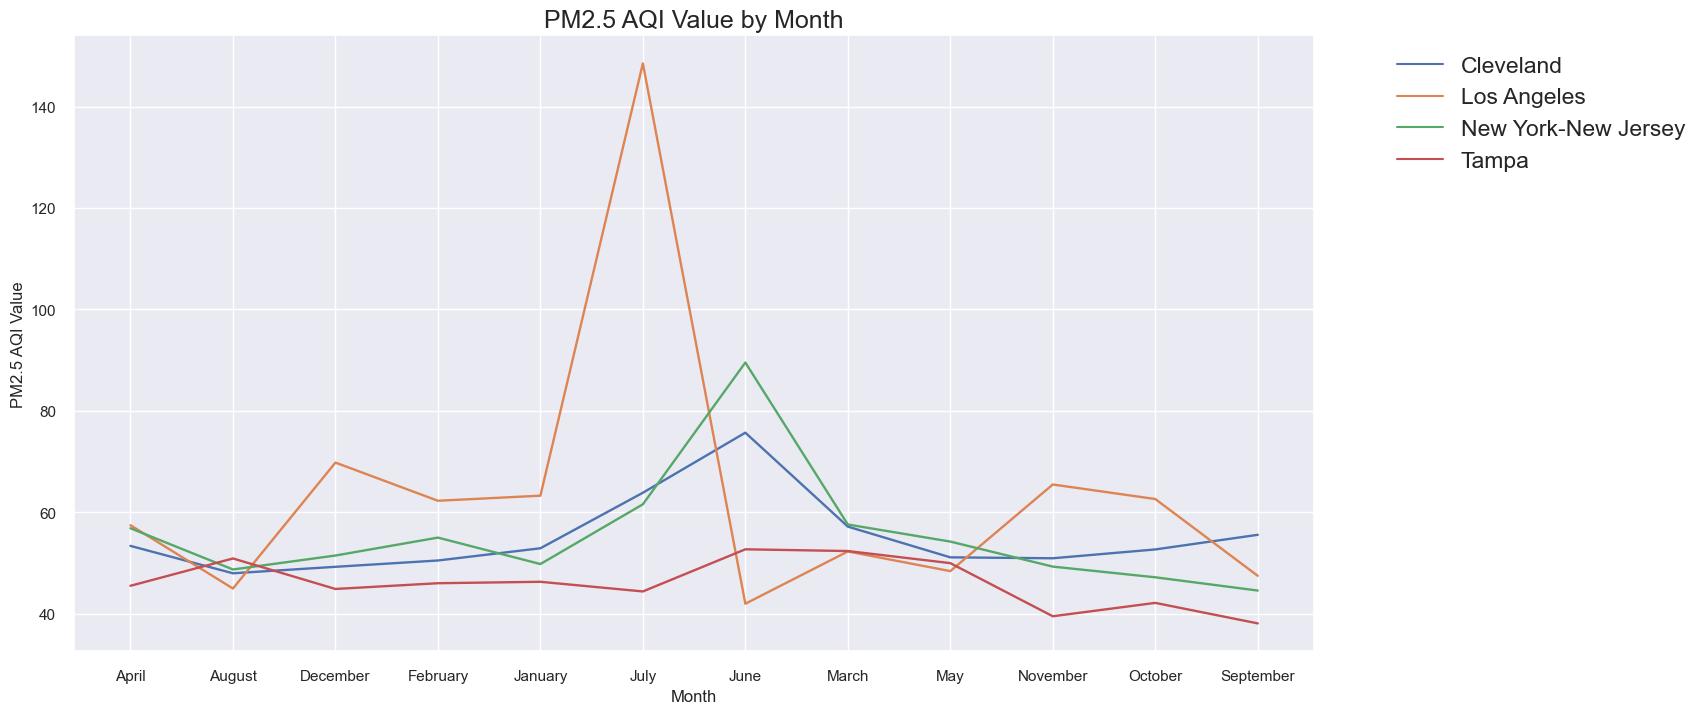

In [34]:
# Plot monthly data
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
sns.set(font_scale = 1)
sns.lineplot(data=per_month, x='Month', y=' AQI Value', hue="City", linewidth= 1.7)
sns.set_context("talk")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xlabel('Month')
plt.ylabel('PM2.5 AQI Value')
plt.title('PM2.5 AQI Value by Month')
plt.show()

#### Weekly

In [35]:
# Create column for day of week
all_cities_copy['Weekday'] = all_cities_copy['Date'].dt.day_name() 
print(all_cities_copy)

# By weekday data
per_day = all_cities_copy.groupby(['Weekday', 'City'],as_index=False).mean()
print(per_day)

          Date Main Pollutant   AQI Value       City     Month    Weekday
0   2022-01-07          PM2.5          52  Cleveland   January     Friday
1   2023-01-07          PM2.5          44  Cleveland   January   Saturday
2   2022-01-08          PM2.5          56  Cleveland   January   Saturday
3   2023-01-08          PM2.5          36  Cleveland   January     Sunday
4   2023-01-09          PM2.5          67  Cleveland   January     Monday
..         ...            ...         ...        ...       ...        ...
886 2022-12-22          PM2.5          45      Tampa  December   Thursday
887 2022-12-26          PM2.5          40      Tampa  December     Monday
888 2022-12-28          PM2.5          45      Tampa  December  Wednesday
889 2022-12-30          PM2.5          34      Tampa  December     Friday
890 2022-12-31          PM2.5          32      Tampa  December   Saturday

[891 rows x 6 columns]
      Weekday                 City   AQI Value
0      Friday            Cleveland   51.8

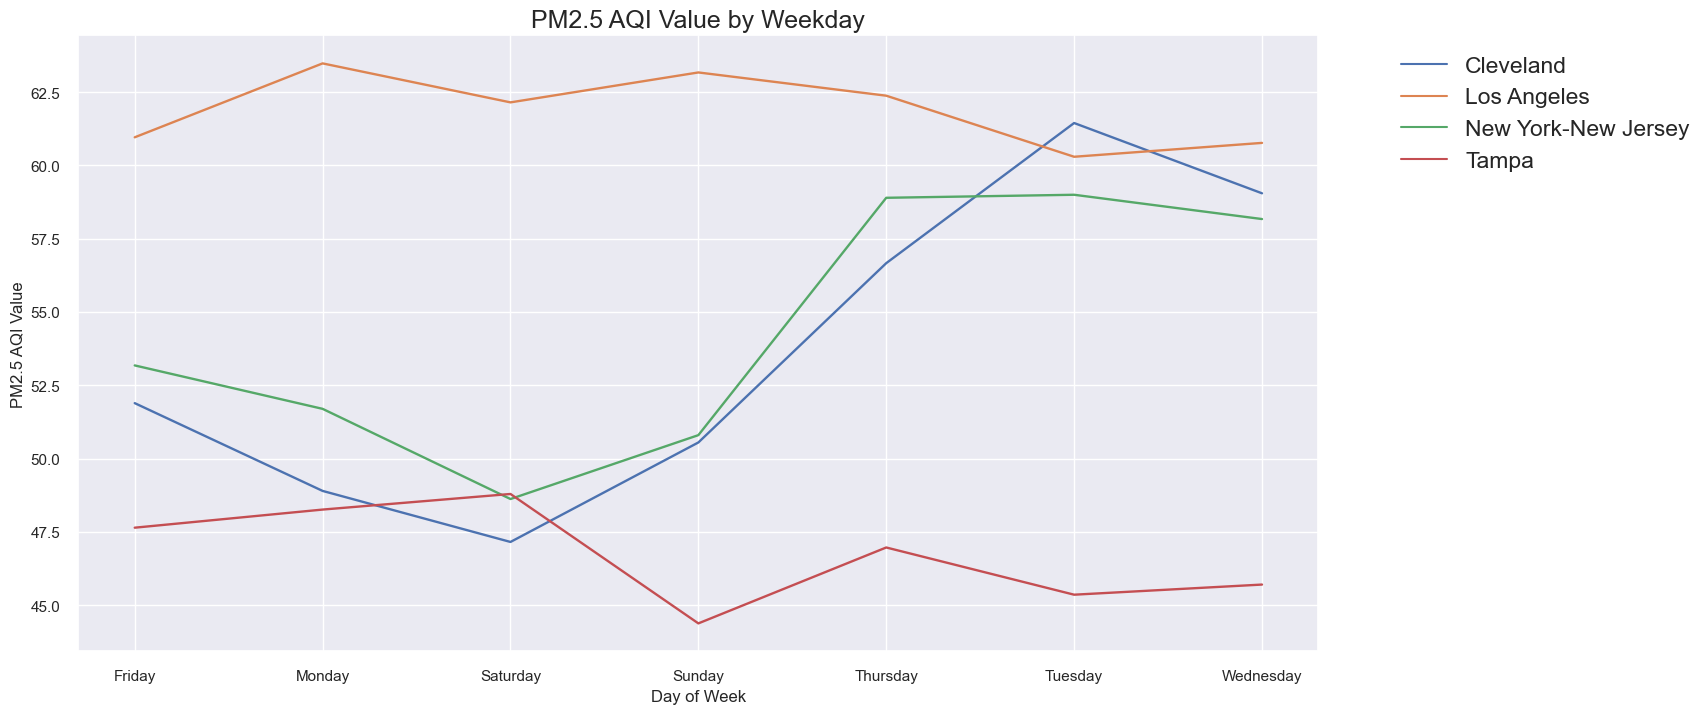

In [37]:
# Plot daily data
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
sns.set(font_scale = 1)
sns.lineplot(data=per_day, x='Weekday', y=' AQI Value', hue="City", linewidth= 1.7)
sns.set_context("talk")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xlabel('Day of Week')
plt.ylabel('PM2.5 AQI Value')
plt.title('PM2.5 AQI Value by Weekday')
plt.show()